# Task 2

In this class, we will develop a baseline for Task 2 using a subset of the lego dataset. We will model the task as an ordinal classification task.

In [ ]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from tqdm import tqdm
import pandas as pd


random.seed(42)


### Connect Colab to Drive (if the dataset is on drive)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "drive/MyDrive/photos.zip"

Archive:  drive/MyDrive/photos.zip
replace photos/1/IMG_20201211_164739.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Load dataset

In the Lego dataset, the images are organized into folders according to the number of legos. In this notebook, we will only consider images with up to 4 legos.

In [ ]:
images_directory = "/content/photos"

# Obtain names of images for training and validation
image_paths = []
num_legos = []
for dirpath, dirnames, filenames in os.walk(images_directory):
    for filename in filenames:
        # Check how many legos the image has
        n = int(dirpath.split(os.sep)[-1])

        if filename.endswith('.jpg'):
            num_legos.append(n)
            image_paths.append(os.path.join(dirpath, filename))

image_paths = np.asarray(image_paths)
num_legos = torch.Tensor(num_legos).to(torch.int64)


# Use csv file to get the split
split_df = pd.read_csv("/content/drive/MyDrive/train_test_split.csv")
# Define the test has th paths that have column is_test = 1
split = np.zeros(len(image_paths))
for i, path in enumerate(image_paths):
    split[i] = int(split_df["/content/" + split_df["filename"] == path]["is_test"].values[0])

test_indexes = np.where(split == 1)[0]
other_indexes =  np.where(split == 0)[0]

# Split the other indexes into train and validation
random.shuffle(other_indexes)
train_indexes = other_indexes[:int(0.8*len(other_indexes))]
valid_indexes = other_indexes[int(0.8*len(other_indexes)):]

num_legos_train = num_legos[train_indexes]
print(f"Train label distribution: {torch.bincount(num_legos_train)}")


# get number of legos for each class 1,2,3,4
num_legos_train = num_legos[train_indexes]
# Get the indexes where num_legos is 1
one_lego_indexes = np.where(num_legos_train == 1)[0]
random.shuffle(one_lego_indexes)
one_lego_indexes = one_lego_indexes[:50]
train_indexes = np.concatenate((train_indexes[np.where(num_legos_train != 1)[0]], train_indexes[one_lego_indexes]))

# Get the indexes where num_legos is 2
num_legos_train = num_legos[train_indexes]
two_lego_indexes = np.where(num_legos_train == 2)[0]
random.shuffle(two_lego_indexes)
two_lego_indexes = two_lego_indexes[:50]
train_indexes = np.concatenate((train_indexes[np.where(num_legos_train != 2)[0]], train_indexes[two_lego_indexes]))


# print label distribution for train
num_legos_train = num_legos[train_indexes]
print(f"Train label distribution: {torch.bincount(num_legos_train)}")

# print relative size of each
total = len(train_indexes) + len(valid_indexes) + len(test_indexes)
print(f"Train size: {len(train_indexes)/total}")
print(f"Validation size: {len(valid_indexes)/total}")
print(f"Test size: {len(test_indexes)/total}")


Train label distribution: tensor([   0, 1741,  240,   46,   31,   13,    4,    5,    9,    6,    3,    4,
           2,    1,    4,    4,    0,    1,    3,    0,    0,    0,    0,    1,
           1,    0,    0,    0,    1,    1,    4,    1,    1])
Train label distribution: tensor([ 0, 50, 50, 46, 31, 13,  4,  5,  9,  6,  3,  4,  2,  1,  4,  4,  0,  1,
         3,  0,  0,  0,  0,  1,  1,  0,  0,  0,  1,  1,  4,  1,  1])
Train size: 0.2338403041825095
Validation size: 0.5057034220532319
Test size: 0.26045627376425856


In [ ]:
class LegosDataset(Dataset):
    def __init__(self, images_filenames, num_legos, transform=None):
        self.images_filenames = images_filenames
        self.transform = transform

        # Transform number of legos into one hot encoding
        self.labels = num_legos - 1

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        label = self.labels[idx]

        # Read image
        image = cv2.imread(image_filename)

        # Convert from BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply the same data augmentation to both input image and target mask
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [ ]:
batch_size = 32
num_workers = 2

# Define transformations to be applied to data
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

# Define datasets and dataloaders
train_dataset = LegosDataset(image_paths[train_indexes], num_legos[train_indexes], transform=transform)
valid_dataset = LegosDataset(image_paths[valid_indexes], num_legos[valid_indexes], transform=transform)
test_dataset = LegosDataset(image_paths[test_indexes], num_legos[test_indexes], transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=num_workers, shuffle=False)

## Defining the model

Load a pre-trained convolutional neural network of your own choice from torchvision. Do not forget to change the last layer to match the number of classes (4)!

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096, 4)
#model = models.inception_v3(pretrained=True)
#model.fc = nn.Linear(2048, 4)

# Freeze all layers except the last one
for name, param in model.named_parameters():
    if "fc" not in name:
        param.requires_grad = False

model.to(device)

Using cuda device


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train the model

Define function to perform one iteration

In [ ]:
@dataclass
class Result:
    accuracy: float
    balanced_accuracy: float
    precision: float
    recall: float
    f1: float


def step(model, dataloader, loss_fn, device, optimizer=None, is_train=True):
    if is_train:
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    all_labels = []
    all_predictions = []

    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        if is_train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(is_train):
            outputs = model(images)
            # Transform InceptionOutputs to tensor
            if isinstance(outputs, torch.Tensor):
                outputs = outputs
            else:
                outputs = outputs.logits
            loss = loss_fn(outputs, labels)

            if is_train:
                loss.backward()
                optimizer.step()

        running_loss += loss.item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(outputs.argmax(dim=1).detach().cpu().numpy())

    loss = running_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_predictions)
    # Get balanced accuracy
    balanced_accuracy = balanced_accuracy_score(all_labels, all_predictions)  # Get balanced accuracy

    return Result(
        accuracy=accuracy,
        balanced_accuracy=balanced_accuracy,
        precision=precision_score(all_labels, all_predictions, average="weighted"),
        recall=recall_score(all_labels, all_predictions, average="weighted"),
        f1=f1_score(all_labels, all_predictions, average="weighted")
    )

Define function to train a model

In [ ]:
def train(model, train_dataloader, valid_dataloader, loss_fn, optimizer, device, num_epochs):
    train_losses = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        train_result = step(model, train_dataloader, loss_fn, device, optimizer=optimizer, is_train=True)
        valid_result = step(model, valid_dataloader, loss_fn, device, is_train=False)

        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"{color.BOLD}Training{color.END}   Loss: {color.DARKCYAN}{train_result.loss:.4f}{color.END}, Accuracy: {color.DARKCYAN}{train_result.accuracy:.4f}{color.END}, Balanced Accuracy: {color.DARKCYAN}{train_result.balanced_accuracy:.4f}{color.END}, Precision: {color.DARKCYAN}{train_result.precision:.4f}{color.END}, Recall: {color.DARKCYAN}{train_result.recall:.4f}{color.END}, F1: {color.DARKCYAN}{train_result.f1:.4f}{color.END}")
        print(f"{color.BOLD}Validation{color.END} Loss: {color.DARKCYAN}{valid_result.loss:.4f}{color.END}, Accuracy: {color.DARKCYAN}{valid_result.accuracy:.4f}{color.END}, Balanced Accuracy: {color.DARKCYAN}{valid_result.balanced_accuracy:.4f}{color.END}, Precision: {color.DARKCYAN}{valid_result.precision:.4f}{color.END}, Recall: {color.DARKCYAN}{valid_result.recall:.4f}{color.END}, F1: {color.DARKCYAN}{valid_result.f1:.4f}{color.END}")
        train_history.loc[len(train_history)] = [train_result.loss, train_result.accuracy]
        val_history.loc[len(val_history)] = [valid_result.loss, valid_result.accuracy]

        train_losses.append(train_result.loss)
        valid_losses.append(valid_result.loss)
        valid_accuracies.append(valid_result.accuracy)

    return train_losses, valid_losses, valid_accuracies

Define loss, optimizer and train the model. Remember that we will model this regression task problem as a classification problem when choosing the loss function!

In [ ]:
# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

print(f"Train size: {len(train_dataloader.dataset)}")

# Train the model
train_losses, valid_losses, valid_accuracies = train(model, train_dataloader, valid_dataloader, loss_fn, optimizer, device, num_epochs)

torch.save(model.state_dict(), "/content/recent.pth")


Train size: 246


100%|██████████| 17/17 [03:17<00:00, 11.63s/it]


Epoch 1/10, train_loss: 1.9297, train_accuracy: 0.3780, valid_loss: 1.3996, valid_accuracy: 0.4981


100%|██████████| 17/17 [03:16<00:00, 11.57s/it]


Epoch 2/10, train_loss: 1.7216, train_accuracy: 0.4350, valid_loss: 1.5658, valid_accuracy: 0.4737


100%|██████████| 17/17 [03:17<00:00, 11.60s/it]


Epoch 3/10, train_loss: 1.5290, train_accuracy: 0.5285, valid_loss: 1.4047, valid_accuracy: 0.5150


100%|██████████| 17/17 [03:20<00:00, 11.77s/it]


Epoch 4/10, train_loss: 1.4349, train_accuracy: 0.4959, valid_loss: 1.3266, valid_accuracy: 0.5677


100%|██████████| 17/17 [03:17<00:00, 11.62s/it]


Epoch 5/10, train_loss: 1.3142, train_accuracy: 0.6057, valid_loss: 1.4688, valid_accuracy: 0.4850


100%|██████████| 17/17 [03:18<00:00, 11.68s/it]


Epoch 6/10, train_loss: 1.2407, train_accuracy: 0.6341, valid_loss: 1.2144, valid_accuracy: 0.6447


100%|██████████| 17/17 [03:22<00:00, 11.92s/it]


Epoch 7/10, train_loss: 1.1425, train_accuracy: 0.7195, valid_loss: 1.4852, valid_accuracy: 0.4455


100%|██████████| 17/17 [03:21<00:00, 11.86s/it]


Epoch 8/10, train_loss: 1.0583, train_accuracy: 0.7439, valid_loss: 1.2397, valid_accuracy: 0.5902


100%|██████████| 17/17 [03:22<00:00, 11.89s/it]


Epoch 9/10, train_loss: 1.0100, train_accuracy: 0.7642, valid_loss: 1.2133, valid_accuracy: 0.6447


100%|██████████| 17/17 [03:20<00:00, 11.77s/it]

Epoch 10/10, train_loss: 0.9395, train_accuracy: 0.7642, valid_loss: 1.3176, valid_accuracy: 0.5320


## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [ ]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

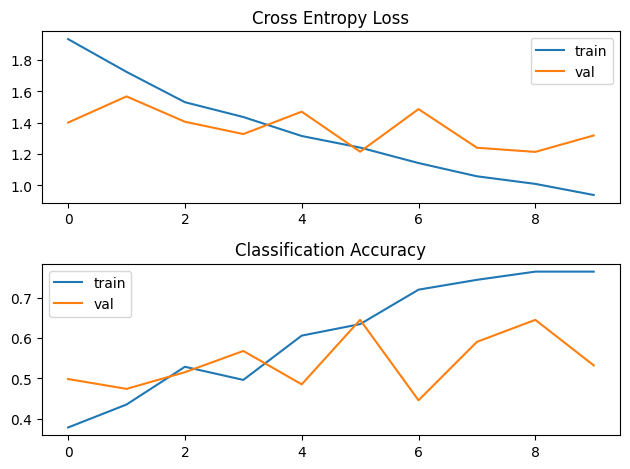

In [ ]:
plotTrainingHistory(train_history, val_history)

In [ ]:
# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

num_epochs = 50

# Train the model
train_losses, valid_losses, valid_accuracies = train(model, train_dataloader, valid_dataloader, loss_fn, optimizer, device, num_epochs)

torch.save(model.state_dict(), "recent_after.pth")

100%|██████████| 5/5 [00:00<00:00,  5.37it/s]


Epoch 1/50, train_loss: 0.8988, train_accuracy: 0.6765, valid_loss: 1.2008, valid_accuracy: 0.4266


100%|██████████| 5/5 [00:00<00:00,  5.41it/s]


Epoch 2/50, train_loss: 0.2780, train_accuracy: 0.9765, valid_loss: 1.2686, valid_accuracy: 0.4476


100%|██████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 3/50, train_loss: 0.1133, train_accuracy: 1.0000, valid_loss: 1.1494, valid_accuracy: 0.5035


100%|██████████| 5/5 [00:01<00:00,  3.62it/s]


Epoch 4/50, train_loss: 0.0511, train_accuracy: 1.0000, valid_loss: 1.0935, valid_accuracy: 0.5105


100%|██████████| 5/5 [00:00<00:00,  5.40it/s]


Epoch 5/50, train_loss: 0.0581, train_accuracy: 0.9941, valid_loss: 1.0899, valid_accuracy: 0.5455


100%|██████████| 5/5 [00:00<00:00,  5.41it/s]


Epoch 6/50, train_loss: 0.0279, train_accuracy: 1.0000, valid_loss: 1.1212, valid_accuracy: 0.5944


100%|██████████| 5/5 [00:00<00:00,  5.21it/s]


Epoch 7/50, train_loss: 0.0496, train_accuracy: 0.9941, valid_loss: 1.1408, valid_accuracy: 0.6084


100%|██████████| 5/5 [00:00<00:00,  5.52it/s]


Epoch 8/50, train_loss: 0.0243, train_accuracy: 1.0000, valid_loss: 1.1369, valid_accuracy: 0.6294


100%|██████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 9/50, train_loss: 0.0192, train_accuracy: 1.0000, valid_loss: 1.1902, valid_accuracy: 0.6014


100%|██████████| 5/5 [00:01<00:00,  3.72it/s]


Epoch 10/50, train_loss: 0.0128, train_accuracy: 1.0000, valid_loss: 1.1818, valid_accuracy: 0.6084


100%|██████████| 5/5 [00:00<00:00,  5.52it/s]


Epoch 11/50, train_loss: 0.0178, train_accuracy: 1.0000, valid_loss: 1.1765, valid_accuracy: 0.5944


100%|██████████| 5/5 [00:00<00:00,  5.38it/s]


Epoch 12/50, train_loss: 0.0091, train_accuracy: 1.0000, valid_loss: 1.1783, valid_accuracy: 0.5944


100%|██████████| 5/5 [00:00<00:00,  5.56it/s]


Epoch 13/50, train_loss: 0.0087, train_accuracy: 1.0000, valid_loss: 1.1980, valid_accuracy: 0.5944


100%|██████████| 5/5 [00:00<00:00,  5.28it/s]


Epoch 14/50, train_loss: 0.0073, train_accuracy: 1.0000, valid_loss: 1.1912, valid_accuracy: 0.6014


100%|██████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 15/50, train_loss: 0.0172, train_accuracy: 1.0000, valid_loss: 1.2141, valid_accuracy: 0.5734


100%|██████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 16/50, train_loss: 0.0051, train_accuracy: 1.0000, valid_loss: 1.2551, valid_accuracy: 0.5664


100%|██████████| 5/5 [00:00<00:00,  5.24it/s]


Epoch 17/50, train_loss: 0.0179, train_accuracy: 1.0000, valid_loss: 1.2472, valid_accuracy: 0.5734


100%|██████████| 5/5 [00:00<00:00,  5.57it/s]


Epoch 18/50, train_loss: 0.0130, train_accuracy: 1.0000, valid_loss: 1.3208, valid_accuracy: 0.5524


100%|██████████| 5/5 [00:00<00:00,  5.24it/s]


Epoch 19/50, train_loss: 0.0081, train_accuracy: 1.0000, valid_loss: 1.2855, valid_accuracy: 0.5664


100%|██████████| 5/5 [00:00<00:00,  5.29it/s]


Epoch 20/50, train_loss: 0.0130, train_accuracy: 1.0000, valid_loss: 1.2623, valid_accuracy: 0.5734


100%|██████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 21/50, train_loss: 0.0046, train_accuracy: 1.0000, valid_loss: 1.2774, valid_accuracy: 0.5944


100%|██████████| 5/5 [00:01<00:00,  3.42it/s]


Epoch 22/50, train_loss: 0.0052, train_accuracy: 1.0000, valid_loss: 1.2745, valid_accuracy: 0.5944


100%|██████████| 5/5 [00:00<00:00,  5.44it/s]


Epoch 23/50, train_loss: 0.0668, train_accuracy: 0.9882, valid_loss: 1.2969, valid_accuracy: 0.5944


100%|██████████| 5/5 [00:00<00:00,  5.36it/s]


Epoch 24/50, train_loss: 0.0090, train_accuracy: 1.0000, valid_loss: 1.3225, valid_accuracy: 0.5734


100%|██████████| 5/5 [00:00<00:00,  5.31it/s]


Epoch 25/50, train_loss: 0.0221, train_accuracy: 0.9941, valid_loss: 1.3023, valid_accuracy: 0.5734


100%|██████████| 5/5 [00:00<00:00,  5.30it/s]


Epoch 26/50, train_loss: 0.0107, train_accuracy: 1.0000, valid_loss: 1.2731, valid_accuracy: 0.5874


100%|██████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 27/50, train_loss: 0.0097, train_accuracy: 1.0000, valid_loss: 1.3071, valid_accuracy: 0.6014


100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


Epoch 28/50, train_loss: 0.0097, train_accuracy: 1.0000, valid_loss: 1.3413, valid_accuracy: 0.6014


100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


Epoch 29/50, train_loss: 0.0039, train_accuracy: 1.0000, valid_loss: 1.3255, valid_accuracy: 0.5874


100%|██████████| 5/5 [00:00<00:00,  5.28it/s]


Epoch 30/50, train_loss: 0.0170, train_accuracy: 1.0000, valid_loss: 1.3118, valid_accuracy: 0.6154


100%|██████████| 5/5 [00:00<00:00,  5.23it/s]


Epoch 31/50, train_loss: 0.0113, train_accuracy: 1.0000, valid_loss: 1.3399, valid_accuracy: 0.6014


 50%|█████     | 3/6 [00:01<00:01,  2.88it/s]


KeyboardInterrupt: 

## Test the model

Evaluate the model in the test set

100%|██████████| 274/274 [01:53<00:00,  2.41it/s]


Test loss: 1.7966, test accuracy: 0.5073


100%|██████████| 274/274 [01:47<00:00,  2.55it/s]


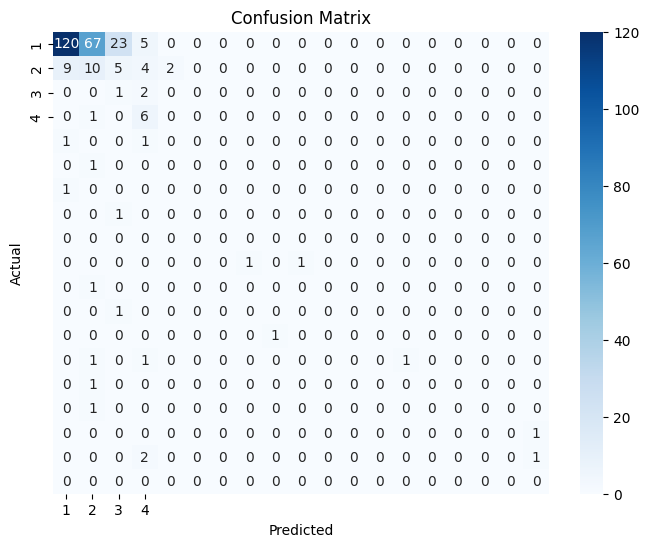

In [ ]:
# Load the best model
#model.load_state_dict(torch.load("/content/recent_after.pth"))

# Evaluate model on test data
test_result = step(model, test_dataloader, loss_fn, device, is_train=False)
print(f"Test Loss: {test_result.loss:.4f}, Accuracy: {test_result.accuracy:.4f}, Balanced Accuracy: {test_result.balanced_accuracy:.4f}, Precision: {test_result.precision:.4f}, Recall: {test_result.recall:.4f}, F1: {test_result.f1:.4f}")

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_labels = []
all_predictions = []

for images, labels in tqdm(test_dataloader):
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(images)

    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(outputs.argmax(dim=1).cpu().numpy())

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(1, len(cm) + 1), yticklabels=range(1, len(cm) + 1))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!